# Introduction to Neural Networks
Author: Marieme Ngom, adapting materials from Bethany Lusch, Asad Khan, Prasanna Balaprakash, Taylor Childers, Corey Adams, Kyle Felker, and Tanwi Mallick.

This tutorial will serve as a gentle introduction to neural networks and deep learning through a hands-on classification problem using the MNIST dataset.

In particular, we will introduce neural networks and how to train and improve their learning capabilities.  We will use the PyTorch Python library.

The [MNIST dataset](http://yann.lecun.com/exdb/mnist/) contains thousands of examples of handwritten numbers, with each digit labeled 0-9.
<img src="https://github.com/914chou/ai-science-training-series/blob/main/02_intro_neural_networks/images/mnist_task.png?raw=1"  align="left"/>



In [71]:
%matplotlib inline

import torch
import torchvision
from torch import nn

import numpy
import matplotlib.pyplot as plt
import time

## The MNIST dataset

We will now download the dataset that contains handwritten digits. MNIST is a popular dataset, so we can download it via the PyTorch library. Note:
- x is for the inputs (images of handwritten digits) and y is for the labels or outputs (digits 0-9)
- We are given "training" and "test" datasets. Training datasets are used to fit the model. Test datasets are saved until the end, when we are satisfied with our model, to estimate how well our model generalizes to new data.

Note that downloading it the first time might take some time.
The data is split as follows:
- 60,000 training examples, 10,000 test examples
- inputs: 1 x 28 x 28 pixels
- outputs (labels): one integer per example

In [72]:
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

In [73]:
train_size = int(0.8 * len(training_data))  # 80% for training
val_size = len(training_data) - train_size  # Remaining 20% for validation
training_data, validation_data = torch.utils.data.random_split(training_data, [train_size, val_size], generator=torch.Generator().manual_seed(55))

In [74]:
print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)

MNIST data loaded: train: 48000  examples, validation:  12000 examples, test: 10000 examples
Input shape torch.Size([1, 28, 28])


Let's take a closer look. Here are the first 10 training digits:

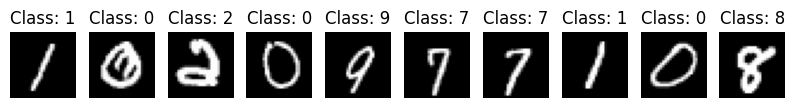

In [75]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(numpy.reshape(training_data[i][0], (28, 28)), cmap="gray")
    plt.title('Class: '+str(training_data[i][1]))

# Generalities:
To train our classifier, we need (besides the data):
- A model that depend on parameters $\mathbf{\theta}$. Here we are going to use neural networks.
- A loss function $J(\mathbf{\theta})$ to measure the capabilities of the model.
- An optimization method.

# Linear Model
Let's begin with a simple linear model: linear regression, like last week.
We add one complication: each example is a vector (flattened image), so the "slope" multiplication becomes a dot product. If the target output is a vector as well, then the multiplication becomes matrix multiplication.

Note, like before, we consider multiple examples at once, adding another dimension to the input.


 <img src="https://github.com/914chou/ai-science-training-series/blob/main/02_intro_neural_networks/images/LinearModel_1.png?raw=1"  align="center"/>



The linear layers in PyTorch perform a basic $xW + b$. These "fully connected" layers connect each input to each output with some weight parameter. We wouldn't expect a simple linear model $f(x) = xW+b$ directly outputting the class label and minimizing mean squared error to work well - the model would output labels like 3.55 and 2.11 instead of skipping to integers.

We now need:
- A loss function $J(\theta)$ where $\theta$ is the list of parameters (here W and b). Last week, we used mean squared error (MSE), but this week let's make two changes that make more sense for classification:
    - Change the output to be a length-10 vector of class probabilities (0 to 1, adding to 1).
    - Cross entropy as the loss function, which is typical for classification. You can read more [here](https://gombru.github.io/2018/05/23/cross_entropy_loss/).

- An optimization method or optimizer such as the stochastic gradient descent (sgd) method, the Adam optimizer, RMSprop, Adagrad etc. Let's start with stochastic gradient descent (sgd), like last week. For far more information about more advanced optimizers than basic SGD, with some cool animations, see https://ruder.io/optimizing-gradient-descent/ or https://distill.pub/2017/momentum/.

- A learning rate. As we learned last week, the learning rate controls how far we move during each step.

In [76]:
class LinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()

        # First, we need to convert the input image to a vector by using
        # nn.Flatten(). For MNIST, it means the second dimension 28*28 becomes 784.
        self.flatten = nn.Flatten()

        # Here, we add a fully connected ("dense") layer that has 28 x 28 = 784 input nodes
        #(one for each pixel in the input image) and 10 output nodes (for probabilities of each class).
        self.layer_1 = nn.Linear(28*28, 10)

    def forward(self, x):

        x = self.flatten(x)
        x = self.layer_1(x)

        return x

In [77]:
linear_model = LinearClassifier()
print(linear_model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.05)

LinearClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1): Linear(in_features=784, out_features=10, bias=True)
)


# Learning
Now we are ready to train our first model. A training step is comprised of:
- A forward pass: the input is passed through the network
- Backpropagation: A backward pass to compute the gradient $\frac{\partial J}{\partial \mathbf{W}}$ of the loss function with respect to the parameters of the network.
- Weight updates $\mathbf{W} = \mathbf{W} - \alpha \frac{\partial J}{\partial \mathbf{W}} $ where $\alpha$ is the learning rate.

How many steps do we take?
- The batch size corresponds to the number of training examples in one pass (forward + backward). A smaller batch size allows the model to learn from individual examples but takes longer to train. A larger batch size requires fewer steps but may result in the model not capturing the nuances in the data. The higher the batch size, the more memory you will require.  
- An epoch means one pass through the whole training data (looping over the batches). Using few epochs can lead to underfitting and using too many can lead to overfitting.
- The choice of batch size and learning rate are important for performance, generalization and accuracy in deep learning.






In [78]:
batch_size = 128

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [79]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # backward pass calculates gradients
        loss.backward()

        # take one step with these gradients
        optimizer.step()

        # resets the gradients
        optimizer.zero_grad()

In [80]:
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size

    accuracy = 100*correct
    return accuracy, loss

In [81]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, linear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, linear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, linear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.5017741878032684, accuracy: 87.63541666666667
Epoch 0: val. loss: 0.49404131351633274, val. accuracy: 87.65833333333333
Epoch 1: training loss: 0.42139660302797954, accuracy: 89.03333333333333
Epoch 1: val. loss: 0.41205910989578737, val. accuracy: 88.86666666666667
Epoch 2: training loss: 0.3874712742169698, accuracy: 89.70208333333333
Epoch 2: val. loss: 0.3775785633541168, val. accuracy: 89.55833333333332
Epoch 3: training loss: 0.3675435369809469, accuracy: 90.15208333333334
Epoch 3: val. loss: 0.35748460651078123, val. accuracy: 89.99166666666667
Epoch 4: training loss: 0.35399221686522164, accuracy: 90.45208333333333
Epoch 4: val. loss: 0.34394882555971756, val. accuracy: 90.28333333333333
CPU times: user 1min 5s, sys: 6.33 s, total: 1min 11s
Wall time: 14.8 s


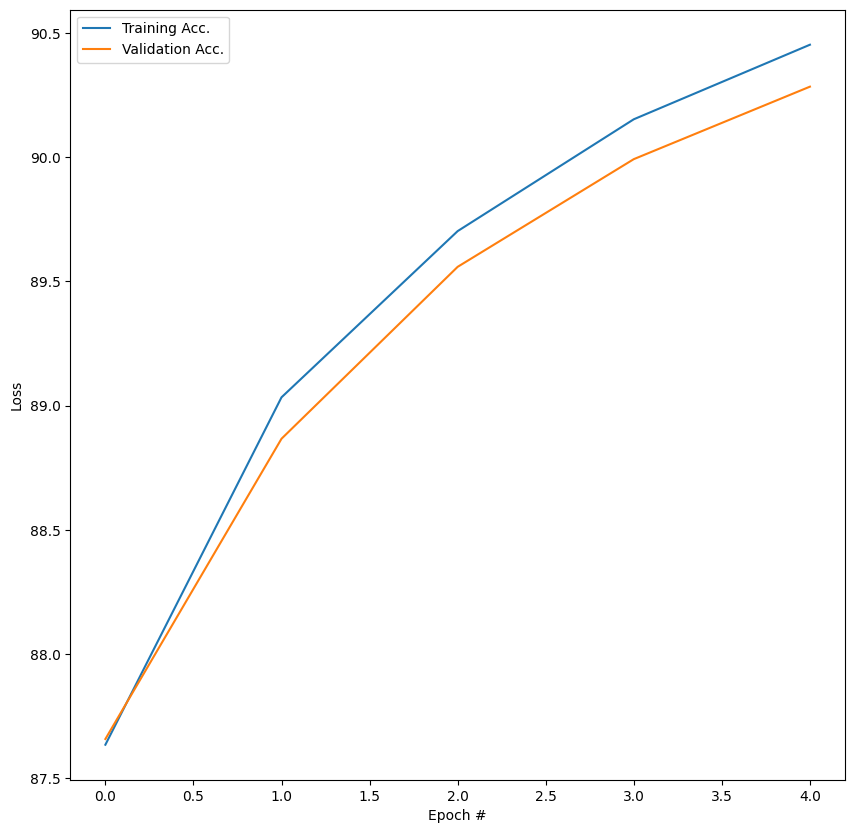

In [82]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

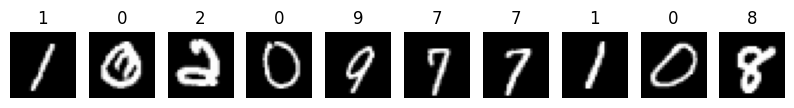

In [83]:
# Visualize how the model is doing on the first 10 examples
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))
linear_model.eval()
batch = next(iter(train_dataloader))
predictions = linear_model(batch[0])

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(batch[0][i,0,:,:], cmap="gray")
    plt.title('%d' % predictions[i,:].argmax())

Exercise: How can you improve the accuracy? Some things you might consider: increasing the number of epochs, changing the learning rate, etc.

# Prediction

Let's see how our model generalizes to the unseen test data.



In [84]:
#create dataloader for test data
# The dataloader makes our dataset iterable
batch_size_test = 256
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [85]:
acc_test, loss_test = evaluate(test_dataloader, linear_model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 0.3327, test accuracy: 90.71%


We can now take a closer look at the results.

Let's define a helper function to show the failure cases of our classifier.

In [86]:
def show_failures(model, dataloader, maxtoshow=10):
    model.eval()
    batch = next(iter(dataloader))
    predictions = model(batch[0])

    rounded = predictions.argmax(1)
    errors = rounded!=batch[1]
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parentheses.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(batch[0].shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(batch[0][i,0,:,:], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], batch[1][i]))
            ii = ii + 1

Here are the first 10 images from the test data that this small model classified to a wrong class:



Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


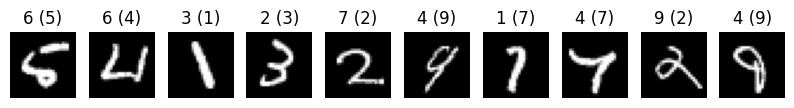

In [87]:
show_failures(linear_model, test_dataloader)

<!-- # Exercise:
- Try changing the loss function,
- Try changing the optimizer -->

# Multilayer Model
Our linear model isn't enough for high accuracy on this dataset. To improve the model, we often need to add more layers and nonlinearities.
<img src="https://github.com/914chou/ai-science-training-series/blob/main/02_intro_neural_networks/images/shallow_nn.png?raw=1"  align="left"/>

The output of this NN can be written as
\begin{equation}\label{eq: NN1d}
  \hat{u}(x) = \sigma_2(\sigma_1(\mathbf{x}\mathbf{W}_1 + \mathbf{b}_1)\mathbf{W}_2 + \mathbf{b}_2),
\end{equation}
where $\mathbf{x}$ is the input, $\mathbf{W}_j$ are the weights of the neural network, $\sigma_j$ the (nonlinear) activation functions, and $\mathbf{b}_j$ its biases. The activation function introduces the nonlinearity and makes it possible to learn more complex tasks. Desirable properties in an activation function include being differentiable, bounded, and monotonic.


Image source: [PragatiBaheti](https://www.v7labs.com/blog/neural-networks-activation-functions)
<img src="https://github.com/914chou/ai-science-training-series/blob/main/02_intro_neural_networks/images/activation.jpeg?raw=1"  align="center"/>

Adding more layers to obtain a deep neural network:
<img src="https://github.com/914chou/ai-science-training-series/blob/main/02_intro_neural_networks/images/deep_nn_annotated.jpg?raw=1"  align="left"/>



# Important things to know
Deep Neural networks can be overly flexible/complicated and "overfit" your data, just like fitting overly complicated polynomials:
<img src="https://github.com/914chou/ai-science-training-series/blob/main/02_intro_neural_networks/images/bias_vs_variance.png?raw=1"  align="left"/>


Vizualization wrt to the accuracy and loss (Image source: [Baeldung](https://www.baeldung.com/cs/ml-underfitting-overfitting)):
<img src="https://github.com/914chou/ai-science-training-series/blob/main/02_intro_neural_networks/images/acc_under_over.webp?raw=1"  align="center"/>


To improve the generalization of our model on previously unseen data, we employ a technique known as regularization, which constrains our optimization problem in order to discourage complex models.

  - Dropout is the commonly used regularization technique. The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.
  - Penalizing the loss function by adding a term such as $\lambda ||\mathbf{W}||^2$ is alsp a commonly used regularization technique. This helps "control" the magnitude of the weights of the network.
    
Vanishing gradients: Gradients become small as they propagate backward through the layers. Squashing activation functions like sigmoid or tanh could cause this.

Exploding gradients: Gradients grow exponentially usually due to "poor" weight initialization.

<!--  <img src="images/test_data_rule.png" width="800" hight="500" align="center"/>
  -->

We can now implement a deep network in PyTorch. nn.Dropout() performs the Dropout operation mentioned earlier

In [88]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [89]:
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

In [90]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.7174816158612569, accuracy: 78.99791666666667
Epoch 0: val. loss: 0.7063074955280791, val. accuracy: 78.95833333333333
Epoch 1: training loss: 0.39031232937177024, accuracy: 88.77708333333332
Epoch 1: val. loss: 0.38139885663986206, val. accuracy: 88.875
Epoch 2: training loss: 0.30076623368263244, accuracy: 91.35416666666667
Epoch 2: val. loss: 0.2941051613777242, val. accuracy: 91.2
Epoch 3: training loss: 0.24653216201066971, accuracy: 92.87708333333333
Epoch 3: val. loss: 0.24344465691358486, val. accuracy: 92.55833333333334
Epoch 4: training loss: 0.20980707412958144, accuracy: 93.83125
Epoch 4: val. loss: 0.20885740680263398, val. accuracy: 93.54166666666667
CPU times: user 1min 9s, sys: 4.43 s, total: 1min 13s
Wall time: 14.8 s


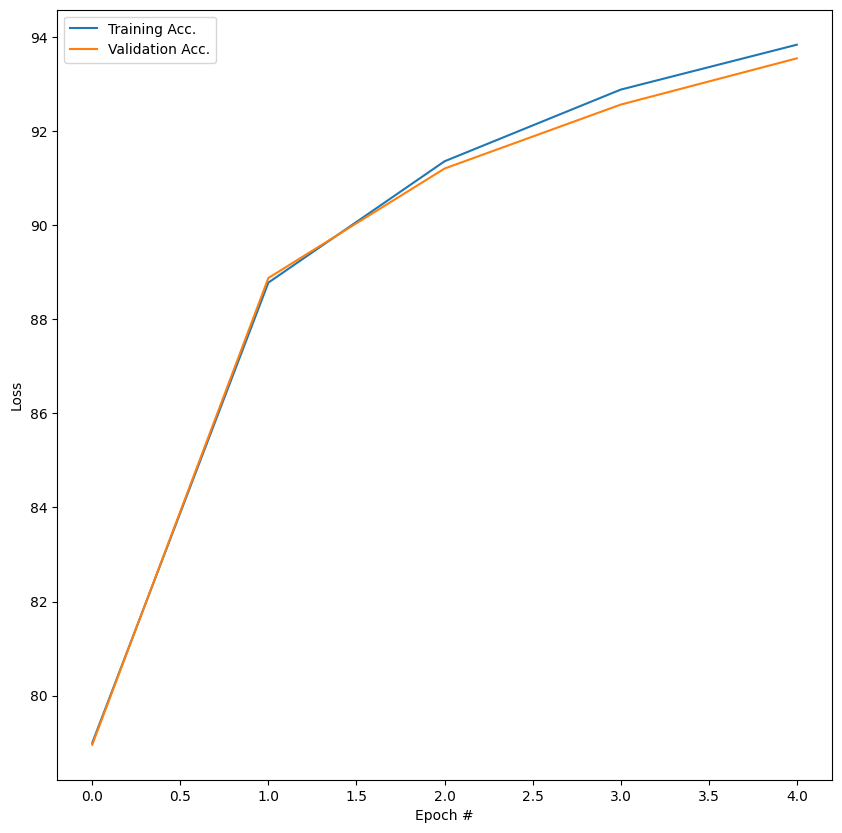

In [91]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


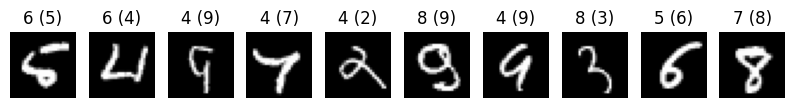

In [92]:
show_failures(nonlinear_model, test_dataloader)

# Recap
To train and validate a neural network model, you need:
- Data split into training/validation/test sets,
- A model with parameters to learn,
- An appropriate loss function,
- An optimizer (with tunable parameters such as learning rate, weight decay etc.) used to learn the parameters of the model.


# Homework

1. Compare the quality of your model when using different:
 - batch sizes,
 - learning rates,
 - activation functions.

3. Bonus: What is a learning rate scheduler?

If you have time, experiment with how to improve the model. Note: training and validation data can be used to compare models, but test data should be saved until the end as a final check of generalization.

In [93]:
def batch_size_and_lr_comparison(batch_size_number, epoch_number, learning_rate_number):

    # Everything is done with a nonlinear model cause I am more unfamiliar with it
    nonlinear_model = NonlinearClassifier()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=learning_rate_number)

    train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size_number)
    val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size_number)

    train_acc_all = []
    val_acc_all = []

    print(f"--- Start training for batch size = {batch_size_number}, epochs = {epoch_number}, and learning_rate = {learning_rate_number} --- ")
    for j in range(epoch_number):
        train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

        # checking on the training loss and accuracy once per epoch
        acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
        train_acc_all.append(acc)
        print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

        # checking on the validation loss and accuracy once per epoch
        val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
        val_acc_all.append(val_acc)
        print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")
    
    return train_acc_all, val_acc_all

### 1. Batch Size Comparison
Three cases are tested: 256, 128, and 64.

In [94]:
epochs = 5
learning_rate = 0.05

In [95]:
%%time

#Test case 1: batch size = 256
train_acc_256, val_acc_256 = batch_size_and_lr_comparison(256, epochs, learning_rate)

--- Start training for batch size = 256, epochs = 5, and learning_rate = 0.05 --- 
Epoch 0: training loss: 2.061637970995396, accuracy: 42.572916666666664
Epoch 0: val. loss: 2.059094677580164, val. accuracy: 43.46666666666666
Epoch 1: training loss: 0.6954405380690352, accuracy: 80.03333333333333
Epoch 1: val. loss: 0.687938168961951, val. accuracy: 79.75
Epoch 2: training loss: 0.48475868460979865, accuracy: 86.06666666666666
Epoch 2: val. loss: 0.4796997010707855, val. accuracy: 85.8
Epoch 3: training loss: 0.4059722269786165, accuracy: 88.37916666666666
Epoch 3: val. loss: 0.4008767864805587, val. accuracy: 88.36666666666667
Epoch 4: training loss: 0.3449842676203302, accuracy: 90.20208333333333
Epoch 4: val. loss: 0.33854995572820623, val. accuracy: 90.18333333333334
CPU times: user 1min 6s, sys: 4.56 s, total: 1min 11s
Wall time: 14.4 s


In [96]:
%%time

# Test case 2: batch size = 128
train_acc_128, val_acc_128 = batch_size_and_lr_comparison(128, epochs, learning_rate)

--- Start training for batch size = 128, epochs = 5, and learning_rate = 0.05 --- 
Epoch 0: training loss: 0.7340720559755961, accuracy: 81.54583333333333
Epoch 0: val. loss: 0.7288504788216125, val. accuracy: 81.5
Epoch 1: training loss: 0.38031908162434896, accuracy: 89.40208333333334
Epoch 1: val. loss: 0.3721969061075373, val. accuracy: 89.425
Epoch 2: training loss: 0.2901021181344986, accuracy: 91.75208333333333
Epoch 2: val. loss: 0.28377807251316434, val. accuracy: 91.71666666666667
Epoch 3: training loss: 0.24247966027259826, accuracy: 93.04583333333333
Epoch 3: val. loss: 0.2367467612345168, val. accuracy: 92.94166666666666
Epoch 4: training loss: 0.2053089049855868, accuracy: 94.08125000000001
Epoch 4: val. loss: 0.20306352819217013, val. accuracy: 93.90833333333333
CPU times: user 1min 9s, sys: 4.25 s, total: 1min 13s
Wall time: 14.8 s


In [97]:
%%time

# Test case 3: batch size = 64
train_acc_64, val_acc_64 = batch_size_and_lr_comparison(64, epochs, learning_rate)

--- Start training for batch size = 64, epochs = 5, and learning_rate = 0.05 --- 
Epoch 0: training loss: 0.4060889775156975, accuracy: 88.28541666666668
Epoch 0: val. loss: 0.40120051824983133, val. accuracy: 88.16666666666667
Epoch 1: training loss: 0.25015417210261026, accuracy: 92.69375
Epoch 1: val. loss: 0.2487884751580497, val. accuracy: 92.40833333333333
Epoch 2: training loss: 0.19165618525942166, accuracy: 94.43958333333333
Epoch 2: val. loss: 0.19495190311461053, val. accuracy: 94.15
Epoch 3: training loss: 0.1596404392644763, accuracy: 95.31875
Epoch 3: val. loss: 0.16808149631709812, val. accuracy: 94.95833333333333
Epoch 4: training loss: 0.13894149526581168, accuracy: 95.87291666666667
Epoch 4: val. loss: 0.15073315274128887, val. accuracy: 95.39166666666667
CPU times: user 1min 12s, sys: 4.47 s, total: 1min 17s
Wall time: 15.6 s


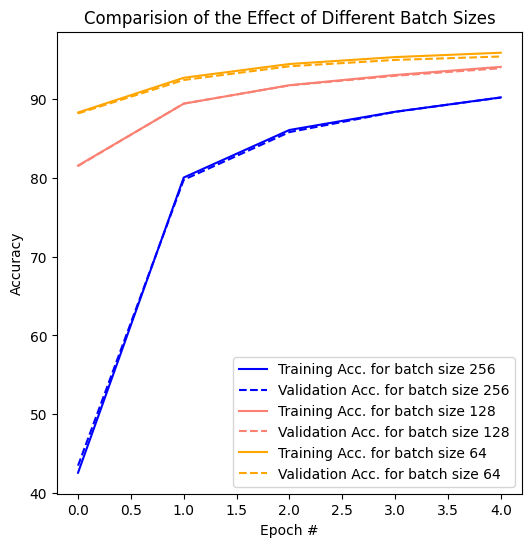

In [98]:
pltsize=1
plt.figure(figsize=(6*pltsize, 6*pltsize))
plt.plot(range(epochs), train_acc_256,label = 'Training Acc. for batch size 256' , color = 'blue')
plt.plot(range(epochs), val_acc_256, label = 'Validation Acc. for batch size 256',linestyle='--', color ='blue')
plt.plot(range(epochs), train_acc_128,label = 'Training Acc. for batch size 128' , color = 'salmon')
plt.plot(range(epochs), val_acc_128, label = 'Validation Acc. for batch size 128',linestyle='--', color ='salmon')
plt.plot(range(epochs), train_acc_64,label = 'Training Acc. for batch size 64' , color = 'orange')
plt.plot(range(epochs), val_acc_64, label = 'Validation Acc. for batch size 64',linestyle='--', color ='orange')
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.title("Comparision of the Effect of Different Batch Sizes")
plt.legend()
plt.show()

### 2. Learning Rate Comparision

In [99]:
epochs = 15
batch_size = 64

In [100]:
%%time

#Test case 1: learning_rate = 0.1
train_acc_01, val_acc_01 = batch_size_and_lr_comparison(batch_size, epochs, 0.1)

--- Start training for batch size = 64, epochs = 15, and learning_rate = 0.1 --- 
Epoch 0: training loss: 0.2798040720522404, accuracy: 91.68125
Epoch 0: val. loss: 0.2811796045366754, val. accuracy: 91.77499999999999
Epoch 1: training loss: 0.17577482390155394, accuracy: 94.76458333333333
Epoch 1: val. loss: 0.18216153818796924, val. accuracy: 94.475
Epoch 2: training loss: 0.16029257629811763, accuracy: 95.32916666666667
Epoch 2: val. loss: 0.17748417151457768, val. accuracy: 94.75833333333334
Epoch 3: training loss: 0.13246745895470183, accuracy: 96.02291666666667
Epoch 3: val. loss: 0.15224809567146796, val. accuracy: 95.39999999999999
Epoch 4: training loss: 0.10972147513429324, accuracy: 96.73958333333333
Epoch 4: val. loss: 0.1265501532990961, val. accuracy: 96.25
Epoch 5: training loss: 0.10199773104737202, accuracy: 96.93958333333333
Epoch 5: val. loss: 0.1263950725948002, val. accuracy: 96.30833333333332
Epoch 6: training loss: 0.08761783169023693, accuracy: 97.36458333333333

In [101]:
%%time

#Test case 2: learning_rate = 0.05
train_acc_005, val_acc_005 = batch_size_and_lr_comparison(batch_size, epochs, 0.05)

--- Start training for batch size = 64, epochs = 15, and learning_rate = 0.05 --- 
Epoch 0: training loss: 0.43209463308254875, accuracy: 87.46458333333334
Epoch 0: val. loss: 0.41925833342557256, val. accuracy: 87.55833333333334
Epoch 1: training loss: 0.25385781621932985, accuracy: 92.6875
Epoch 1: val. loss: 0.2487250233584262, val. accuracy: 92.80833333333334
Epoch 2: training loss: 0.19606256815294423, accuracy: 94.325
Epoch 2: val. loss: 0.19723055963503552, val. accuracy: 94.125
Epoch 3: training loss: 0.15863630221039057, accuracy: 95.37916666666668
Epoch 3: val. loss: 0.163670686430278, val. accuracy: 95.15833333333333
Epoch 4: training loss: 0.13786338126907746, accuracy: 95.95208333333333
Epoch 4: val. loss: 0.14600058889729864, val. accuracy: 95.64166666666667
Epoch 5: training loss: 0.12198729105914632, accuracy: 96.43541666666667
Epoch 5: val. loss: 0.13895311665305116, val. accuracy: 95.90833333333333
Epoch 6: training loss: 0.11020133318627874, accuracy: 96.752083333333

In [102]:
%%time

#Test case 3: learning_rate = 0.025
train_acc_0025, val_acc_0025 = batch_size_and_lr_comparison(batch_size, epochs, 0.025)

--- Start training for batch size = 64, epochs = 15, and learning_rate = 0.025 --- 
Epoch 0: training loss: 0.7751339909235636, accuracy: 77.09375
Epoch 0: val. loss: 0.7679389838842635, val. accuracy: 77.45833333333333
Epoch 1: training loss: 0.40301938233772916, accuracy: 88.67916666666666
Epoch 1: val. loss: 0.39327059440473294, val. accuracy: 88.8
Epoch 2: training loss: 0.301870744963487, accuracy: 91.34583333333333
Epoch 2: val. loss: 0.29307964035963757, val. accuracy: 91.25
Epoch 3: training loss: 0.25095754276712734, accuracy: 92.79166666666666
Epoch 3: val. loss: 0.2451233124717119, val. accuracy: 92.66666666666666
Epoch 4: training loss: 0.21186583388845126, accuracy: 93.98333333333333
Epoch 4: val. loss: 0.20981031858382074, val. accuracy: 93.625
Epoch 5: training loss: 0.18694752838710943, accuracy: 94.74583333333332
Epoch 5: val. loss: 0.187787789157889, val. accuracy: 94.25
Epoch 6: training loss: 0.17098990846922, accuracy: 95.05416666666666
Epoch 6: val. loss: 0.174023

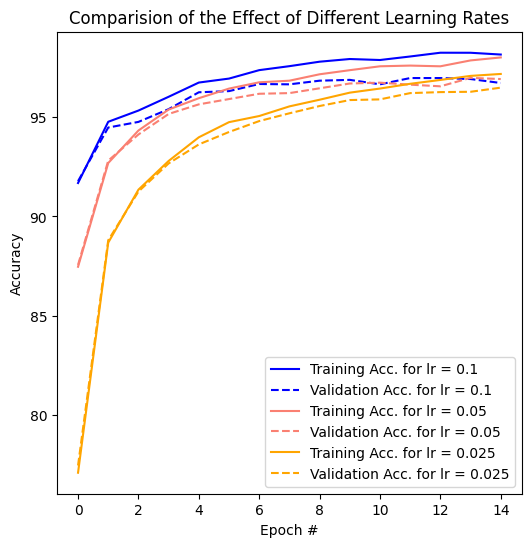

In [103]:
pltsize=1
plt.figure(figsize=(6*pltsize, 6*pltsize))
plt.plot(range(epochs), train_acc_01,label = 'Training Acc. for lr = 0.1' , color = 'blue')
plt.plot(range(epochs), val_acc_01, label = 'Validation Acc. for lr = 0.1',linestyle='--', color ='blue')
plt.plot(range(epochs), train_acc_005,label = 'Training Acc. for lr = 0.05' , color = 'salmon')
plt.plot(range(epochs), val_acc_005, label = 'Validation Acc. for lr = 0.05',linestyle='--', color ='salmon')
plt.plot(range(epochs), train_acc_0025,label = 'Training Acc. for lr = 0.025' , color = 'orange')
plt.plot(range(epochs), val_acc_0025, label = 'Validation Acc. for lr = 0.025',linestyle='--', color ='orange')
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.title("Comparision of the Effect of Different Learning Rates")
plt.legend()
plt.show()

### 3. Comparison between activation functions

In [104]:
learning_rate_number = 0.05
batch_size_number = 128
epoch_number = 10

In [105]:
# Relu
class NonlinearClassifierRelu(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [106]:
nonlinear_model = NonlinearClassifierRelu()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=learning_rate_number)


train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size_number)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size_number)

train_acc_relu = []
val_acc_relu = []

print(f"--- Start training for batch size = {batch_size_number}, epochs = {epoch_number}, and learning_rate = {learning_rate_number} --- ")
for j in range(epoch_number):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_relu.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_relu.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

--- Start training for batch size = 128, epochs = 10, and learning_rate = 0.05 --- 
Epoch 0: training loss: 0.8124553058942159, accuracy: 75.68333333333334
Epoch 0: val. loss: 0.808636080077354, val. accuracy: 75.68333333333334
Epoch 1: training loss: 0.41784575815995534, accuracy: 88.18333333333334
Epoch 1: val. loss: 0.4121619919513134, val. accuracy: 88.05833333333334
Epoch 2: training loss: 0.3156182908217112, accuracy: 90.88958333333333
Epoch 2: val. loss: 0.3126685782632929, val. accuracy: 90.91666666666667
Epoch 3: training loss: 0.25542290729284284, accuracy: 92.75625
Epoch 3: val. loss: 0.25364730261424756, val. accuracy: 92.43333333333334
Epoch 4: training loss: 0.22380889240900675, accuracy: 93.50833333333334
Epoch 4: val. loss: 0.22666332934131014, val. accuracy: 93.2
Epoch 5: training loss: 0.19204379347960154, accuracy: 94.37291666666667
Epoch 5: val. loss: 0.19489722873302215, val. accuracy: 94.25833333333333
Epoch 6: training loss: 0.16831642292936644, accuracy: 95.0145

In [107]:
# Sigmoid
class NonlinearClassifierSigmoid(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.Sigmoid(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Sigmoid(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Sigmoid(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [108]:
nonlinear_model = NonlinearClassifierSigmoid()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=learning_rate_number)


train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size_number)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size_number)

train_acc_sigmoid = []
val_acc_sigmoid  = []

print(f"--- Start training for batch size = {batch_size_number}, epochs = {epoch_number}, and learning_rate = {learning_rate_number} --- ")
for j in range(epoch_number):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_sigmoid.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_sigmoid.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

--- Start training for batch size = 128, epochs = 10, and learning_rate = 0.05 --- 
Epoch 0: training loss: 2.302282102584839, accuracy: 11.2375
Epoch 0: val. loss: 2.3023081535988665, val. accuracy: 11.233333333333333
Epoch 1: training loss: 2.3021150328318276, accuracy: 11.2375
Epoch 1: val. loss: 2.3021397616000887, val. accuracy: 11.233333333333333
Epoch 2: training loss: 2.301933863957723, accuracy: 11.2375
Epoch 2: val. loss: 2.301956224948802, val. accuracy: 11.233333333333333
Epoch 3: training loss: 2.3017374515533446, accuracy: 11.2375
Epoch 3: val. loss: 2.3017589183563882, val. accuracy: 11.233333333333333
Epoch 4: training loss: 2.301511598587036, accuracy: 11.2375
Epoch 4: val. loss: 2.3015327199976494, val. accuracy: 11.233333333333333
Epoch 5: training loss: 2.301240949630737, accuracy: 11.2375
Epoch 5: val. loss: 2.301260971008463, val. accuracy: 11.233333333333333
Epoch 6: training loss: 2.3009127966562906, accuracy: 11.2375
Epoch 6: val. loss: 2.3009311239770116, val.

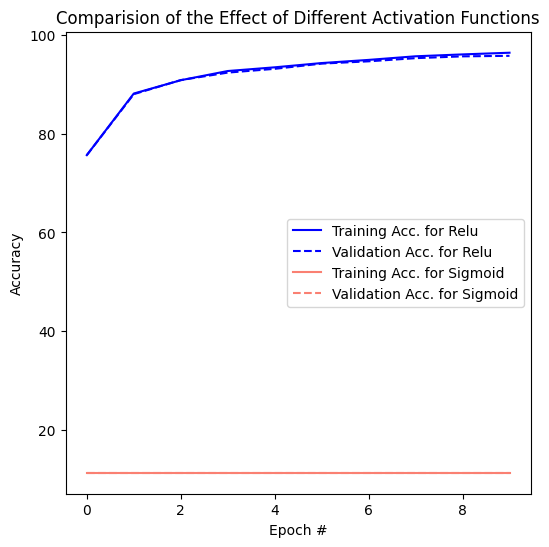

In [110]:
pltsize=1
plt.figure(figsize=(6*pltsize, 6*pltsize))
plt.plot(range(epoch_number), train_acc_relu,label = 'Training Acc. for Relu' , color = 'blue')
plt.plot(range(epoch_number), val_acc_relu, label = 'Validation Acc. for Relu',linestyle='--', color ='blue')
plt.plot(range(epoch_number), train_acc_sigmoid,label = 'Training Acc. for Sigmoid' , color = 'salmon')
plt.plot(range(epoch_number), val_acc_sigmoid, label = 'Validation Acc. for Sigmoid',linestyle='--', color ='salmon')
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.title("Comparision of the Effect of Different Activation Functions")
plt.legend()
plt.show()